<a href="https://colab.research.google.com/github/Pejota021/Petshop/blob/main/SERIEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalação de dependências (execute no Colab)
!pip install requests pandas matplotlib pyspark --quiet
!apt-get update -q
!apt-get install -y openjdk-11-jdk-headless -qq


Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,123 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Pack

In [2]:
# Cole sua API key aqui (substitua a string vazia)
API_KEY = "1c3128c5b38ea53a2d1703635055e5c8"
import os
os.environ['API_FOOTBALL_KEY'] = API_KEY
HEADERS = {'x-apisports-key': API_KEY}
LEAGUE_ID = 71
API_BASE = "https://v3.football.api-sports.io"


In [5]:
import requests
r = requests.get("https://v3.football.api-sports.io/status", headers={"x-apisports-key": API_KEY})
print(r.json())


{'get': 'status', 'parameters': [], 'errors': [], 'results': 0, 'paging': {'current': 1, 'total': 1}, 'response': {'account': {'firstname': 'João Pedro', 'lastname': 'Rodrigues da Silva', 'email': 'joao2005crf@gmail.com'}, 'subscription': {'plan': 'Free', 'end': '2026-11-10T00:00:00+00:00', 'active': True}, 'requests': {'current': 4, 'limit_day': 100}}}


In [3]:
import requests, pandas as pd
def get_latest_available_season(league_id=LEAGUE_ID):
    url = f"{API_BASE}/leagues?id={league_id}"
    r = requests.get(url, headers=HEADERS); r.raise_for_status()
    seasons = r.json()['response'][0]['seasons']
    current = [s for s in seasons if s.get('current')]
    if current:
        return current[0]['year']
    for s in reversed(seasons):
        if s.get('coverage', {}).get('standings', False):
            return s['year']
    return sorted(seasons, key=lambda x: x['year'], reverse=True)[0]['year']

SEASON = get_latest_available_season()
print('SEASON =', SEASON)


SEASON = 2025


In [6]:
import requests

def get_valid_season(league_id=71):
    url = f"https://v3.football.api-sports.io/leagues?id={league_id}"
    r = requests.get(url, headers={"x-apisports-key": API_KEY})
    r.raise_for_status()
    data = r.json().get("response", [])
    if not data:
        raise SystemExit("❌ Nenhum retorno da API. Verifique sua chave API-Football.")
    seasons = data[0]["seasons"]

    # 1️⃣ tenta temporada atual
    for s in seasons:
        if s.get("current"):
            test_year = s["year"]
            test_url = f"https://v3.football.api-sports.io/standings?league={league_id}&season={test_year}"
            resp = requests.get(test_url, headers={"x-apisports-key": API_KEY})
            if resp.ok and resp.json().get("response"):
                print(f"🏆 Temporada atual detectada: {test_year}")
                return test_year
            else:
                print(f"⚠️ Temporada atual ({test_year}) sem dados — tentando anterior...")

    # 2️⃣ fallback: encontra a mais recente com standings disponíveis
    for s in sorted(seasons, key=lambda x: x["year"], reverse=True):
        test_year = s["year"]
        test_url = f"https://v3.football.api-sports.io/standings?league={league_id}&season={test_year}"
        resp = requests.get(test_url, headers={"x-apisports-key": API_KEY})
        if resp.ok and resp.json().get("response"):
            print(f"📅 Usando temporada mais recente com dados: {test_year}")
            return test_year

    raise SystemExit("⚠️ Nenhuma temporada com dados disponíveis encontrada.")

SEASON = get_valid_season()
print("✅ Temporada confirmada:", SEASON)


⚠️ Temporada atual (2025) sem dados — tentando anterior...
📅 Usando temporada mais recente com dados: 2023
✅ Temporada confirmada: 2023


In [14]:
def get_standings(league_id=LEAGUE_ID, season=SEASON):
    url = f"{API_BASE}/standings?league={league_id}&season={season}"
    r = requests.get(url, headers=HEADERS); r.raise_for_status()
    data = r.json()
    if not data['response']:
        display(pd.DataFrame())
        raise SystemExit("No standings data for season detected. Paste a valid API key and rerun.")
    standings = data['response'][0]['league']['standings'][0]
    df = pd.json_normalize(standings)
    df = df.rename(columns={
        'team.name':'team','points':'points','all.played':'played','all.win':'win',
        'all.draw':'draw','all.lose':'lose','all.goals.for':'gf','all.goals.against':'ga'
    })[['rank','team','played','win','draw','lose','gf','ga','points']]
    return df

standings_df = get_standings()
standings_df.to_csv('standings_brasileirao.csv', index=False)
display(standings_df.head(20))


,rank,team,played,win,draw,lose,gf,ga,points
0,1,Palmeiras,38,20,10,8,64,33,70
1,2,Gremio,38,21,5,12,63,56,68
2,3,Atletico-MG,38,19,9,10,52,32,66
3,4,Flamengo,38,19,9,10,56,42,66
4,5,Botafogo,38,18,10,10,58,37,64
5,6,RB Bragantino,38,17,11,10,49,35,62
6,7,Fluminense,38,16,8,14,51,47,56
7,8,Atletico Paranaense,38,14,14,10,51,43,56
8,9,Internacional,38,15,10,13,46,45,55
9,10,Fortaleza EC,38,15,9,14,45,44,54


In [13]:
def get_players_goals_assists(league_id=LEAGUE_ID, season=SEASON):
    url_g = f"{API_BASE}/players/topscorers?league={league_id}&season={season}"
    r_g = requests.get(url_g, headers=HEADERS); r_g.raise_for_status()
    top_scorers = r_g.json()['response']

    url_a = f"{API_BASE}/players/topassists?league={league_id}&season={season}"
    r_a = requests.get(url_a, headers=HEADERS); r_a.raise_for_status()
    top_assists = r_a.json()['response']

    g_df = pd.json_normalize(top_scorers)
    if 'statistics' in g_df.columns:
        g_df['goals'] = g_df['statistics'].apply(lambda x: x[0]['goals']['total'] if x else 0)
        g_df['team'] = g_df['statistics'].apply(lambda x: x[0]['team']['name'] if x else '')
    else:
        g_df['goals']=0; g_df['team']=''

    a_df = pd.json_normalize(top_assists)
    if 'statistics' in a_df.columns:
        a_df['assists'] = a_df['statistics'].apply(lambda x: x[0]['goals']['assists'] if x else 0)
        a_df['team'] = a_df['statistics'].apply(lambda x: x[0]['team']['name'] if x else '')
    else:
        a_df['assists']=0; a_df['team']=''

    g = g_df[['player.name','team','goals']].rename(columns={'player.name':'player'})
    a = a_df[['player.name','team','assists']].rename(columns={'player.name':'player'})
    merged = pd.merge(g, a, on=['player','team'], how='outer').fillna(0)
    merged['goals'] = merged['goals'].astype(int); merged['assists'] = merged['assists'].astype(int)
    merged = merged.sort_values(['goals','assists'], ascending=[False,False]).reset_index(drop=True)
    return merged

players_df = get_players_goals_assists()
players_df.to_csv('players_goals_assists.csv', index=False)
display(players_df.head(30))


,player,team,goals,assists
0,Paulinho,Atletico-MG,18,0
1,L. Suárez,Gremio,17,11
2,Tiquinho Soares,Botafogo,17,0
3,Hulk,Atletico-MG,15,10
4,Marcos Leonardo,Santos,13,0
5,Pedro,Flamengo,13,0
6,Deyverson,Cuiaba,12,0
7,Robson,Coritiba,12,0
8,Vitor Roque,Atletico Paranaense,12,0
9,Eduardo Sasha,RB Bragantino,11,0


In [9]:
import time
def get_team_statistics(league_id=LEAGUE_ID, season=SEASON):
    url = f"{API_BASE}/teams?league={league_id}&season={season}"
    r = requests.get(url, headers=HEADERS); r.raise_for_status()
    teams = r.json()['response']
    stats_list = []
    for t in teams:
        tid = t['team']['id']; tname = t['team']['name']
        url_stat = f"{API_BASE}/teams/statistics?league={league_id}&season={season}&team={tid}"
        rstat = requests.get(url_stat, headers=HEADERS)
        if rstat.status_code != 200: continue
        j = rstat.json()['response']
        def safe_get(d, *keys):
            for k in keys:
                if not isinstance(d, dict): return None
                d = d.get(k)
            return d
        shots_avg = safe_get(j, 'shots', 'total', 'average') or None
        shots_on_avg = safe_get(j, 'shots', 'on', 'average') or None
        passes_avg = safe_get(j, 'passes', 'total', 'average') or None
        possession_avg = safe_get(j, 'possession', 'average') or None
        stats_list.append({'team': tname, 'shots_pg': shots_avg, 'shots_on_target_pg': shots_on_avg,
                           'passes_pg': passes_avg, 'possession_%': possession_avg})
        time.sleep(0.6)
    return pd.DataFrame(stats_list)

team_stats_df = get_team_statistics()
team_stats_df.to_csv('team_stats_brasileirao.csv', index=False)
display(team_stats_df.head(20))


,team,shots_pg,shots_on_target_pg,passes_pg,possession_%
0,Bahia,None,None,None,None
1,Internacional,None,None,None,None
2,Botafogo,None,None,None,None
3,Palmeiras,None,None,None,None
4,Fluminense,None,None,None,None
5,America Mineiro,None,None,None,None
6,Sao Paulo,None,None,None,None
7,Flamengo,None,None,None,None
8,Santos,None,None,None,None
9,Gremio,None,None,None,None


No charts were generated by quickchart


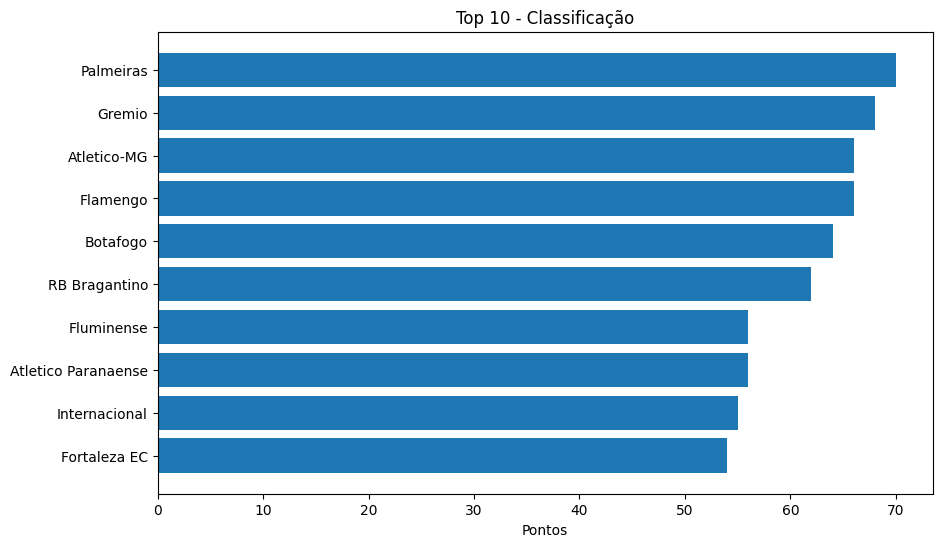

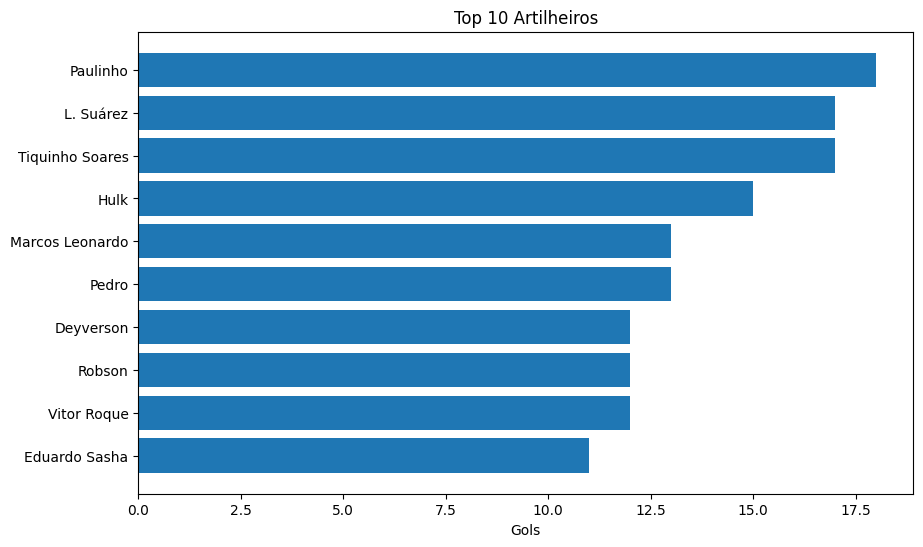

In [10]:
import matplotlib.pyplot as plt
try:
    top10 = standings_df.head(10)
    plt.figure(figsize=(10,6))
    plt.barh(top10['team'], top10['points']); plt.gca().invert_yaxis(); plt.xlabel('Pontos'); plt.title('Top 10 - Classificação'); plt.show()
except: pass

try:
    topg = players_df.head(10)
    plt.figure(figsize=(10,6))
    plt.barh(topg['player'], topg['goals']); plt.gca().invert_yaxis(); plt.xlabel('Gols'); plt.title('Top 10 Artilheiros'); plt.show()
except: pass


In [11]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').appName('APIFootballSerieA').getOrCreate()
try:
    if 'standings_df' in globals() and not standings_df.empty:
        sdf = spark.createDataFrame(standings_df); sdf.show(10)
finally:
    spark.stop()


+----+-------------------+------+---+----+----+---+---+------+
|rank|               team|played|win|draw|lose| gf| ga|points|
+----+-------------------+------+---+----+----+---+---+------+
|   1|          Palmeiras|    38| 20|  10|   8| 64| 33|    70|
|   2|             Gremio|    38| 21|   5|  12| 63| 56|    68|
|   3|        Atletico-MG|    38| 19|   9|  10| 52| 32|    66|
|   4|           Flamengo|    38| 19|   9|  10| 56| 42|    66|
|   5|           Botafogo|    38| 18|  10|  10| 58| 37|    64|
|   6|      RB Bragantino|    38| 17|  11|  10| 49| 35|    62|
|   7|         Fluminense|    38| 16|   8|  14| 51| 47|    56|
|   8|Atletico Paranaense|    38| 14|  14|  10| 51| 43|    56|
|   9|      Internacional|    38| 15|  10|  13| 46| 45|    55|
|  10|       Fortaleza EC|    38| 15|   9|  14| 45| 44|    54|
+----+-------------------+------+---+----+----+---+---+------+
only showing top 10 rows

